In [ ]:
!apt-get install swig build-essential python3-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
python3-dev is already the newest version (3.10.6-1~22.04.1).
python3-dev set to manually installed.
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (1,004 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 126333 files and directories currently installed.)
Preparing to unpack ...

In [ ]:
!pip install box2d-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.5/374.5 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.8-cp311-cp311-linux_x86_64.whl size=2351232 sha256=237830657ee624546fb1b8d8cb61852381aea69d478d646ec97d915304dfb131
  Stored in directory: /root/.cache/pip/wheels/3f/95/02/4cb5adc9f6dcaeb9639c2271f630a66ab4440102414804c45c
Successfully built box2d-py


In [69]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [70]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, is_continuous):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh()
        )
        self.is_continuous = is_continuous
        if is_continuous:
            self.mean = nn.Linear(256, action_dim)
            self.log_std = nn.Parameter(torch.zeros(action_dim))
        else:
            self.logits = nn.Linear(256, action_dim)
        self.critic = nn.Linear(256, 1)

    def forward(self, state):
        x = self.shared(state)
        if self.is_continuous:
            mean = self.mean(x)
            std = torch.exp(self.log_std)
            return mean, std, self.critic(x)
        else:
            logits = self.logits(x)
            return logits, self.critic(x)

In [71]:
class RunningNorm:
    def __init__(self, shape, epsilon=1e-4):
        self.mean = np.zeros(shape, dtype=np.float32)
        self.var = np.ones(shape, dtype=np.float32)
        self.count = epsilon

    def update(self, x):
        x = np.array(x)
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        delta = batch_mean - self.mean
        tot_count = self.count + batch_count
        self.mean += delta * batch_count / tot_count
        m_a = self.var * self.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + (delta ** 2) * self.count * batch_count / tot_count
        self.var = M2 / tot_count
        self.count = tot_count

    def normalize(self, x):
        return (x - self.mean) / (np.sqrt(self.var) + 1e-8)

In [72]:
class PPOMemory:
    def __init__(self, batch_size, actions_are_continuous):
        self.batch_size = batch_size
        self.actions_are_continuous = actions_are_continuous
        self.clear()

    def store(self, state, action, reward, done, log_prob, value):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.dones.append(done)
        self.log_probs.append(log_prob)
        self.values.append(value)

    def clear(self):
        self.states, self.actions, self.rewards = [], [], []
        self.dones, self.log_probs, self.values = [], [], []

    def __len__(self):
        return len(self.states)

    def compute_returns(self, last_value, gamma=0.99, lam=0.95):
        self.values.append(last_value)
        advantages, returns, gae = [], [], 0
        for i in reversed(range(len(self.rewards))):
            delta = self.rewards[i] + gamma * self.values[i + 1] * (1 - self.dones[i]) - self.values[i]
            gae = delta + gamma * lam * (1 - self.dones[i]) * gae
            advantages.insert(0, gae)
            returns.insert(0, gae + self.values[i])
        self.returns = returns
        self.advantages = advantages

    def get_batches(self):
        n = len(self.states)
        indices = np.arange(n)
        np.random.shuffle(indices)
        for i in range(0, n, self.batch_size):
            batch_idx = indices[i:i + self.batch_size]
            states = torch.FloatTensor(np.array(self.states)[batch_idx]).to(device)
            actions = torch.FloatTensor(np.array(self.actions)[batch_idx]).to(device) if self.actions_are_continuous else torch.LongTensor(np.array(self.actions)[batch_idx]).to(device)
            old_log_probs = torch.FloatTensor(np.array(self.log_probs)[batch_idx]).to(device)
            returns = torch.FloatTensor(np.array(self.returns)[batch_idx]).to(device)
            advantages = torch.FloatTensor(np.array(self.advantages)[batch_idx]).to(device)
            yield states, actions, old_log_probs, returns, advantages

In [73]:
def train_ppo(env_name="CartPole-v1", episodes=2000, is_continuous=False,
              lr=3e-4, clip_ratio=0.2, gamma=0.99, lam=0.95,
              update_steps=2048, mini_epochs=10, batch_size=64):

    env = gym.make(env_name)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0] if is_continuous else env.action_space.n

    model = ActorCritic(obs_dim, act_dim, is_continuous).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    norm = RunningNorm(shape=obs_dim)
    memory = PPOMemory(batch_size=batch_size, actions_are_continuous=is_continuous)

    all_rewards = []
    reward_queue = deque(maxlen=100)

    for ep in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        step = 0

        while True:
            norm_state = norm.normalize(state)
            state_tensor = torch.FloatTensor(norm_state).unsqueeze(0).to(device)

            with torch.no_grad():
                if is_continuous:
                    mean, std, value = model(state_tensor)
                    dist = torch.distributions.Normal(mean, std)
                    action = dist.sample()
                    action_clipped = torch.clamp(action, torch.tensor(env.action_space.low).to(device),
                                               torch.tensor(env.action_space.high).to(device))
                    log_prob = dist.log_prob(action).sum(dim=-1)
                    action_np = action_clipped.squeeze(0).cpu().numpy()
                else:
                    logits, value = model(state_tensor)
                    dist = torch.distributions.Categorical(logits=logits)
                    action = dist.sample()
                    log_prob = dist.log_prob(action)
                    action_np = action.item()

            next_state, reward, terminated, truncated, _ = env.step(action_np)
            done = terminated or truncated
            total_reward += reward

            memory.store(norm_state, action_np, reward, done, log_prob.item(), value.item())
            norm.update(np.array([next_state]))

            state = next_state
            step += 1

            if done:
                break

            if len(memory) >= update_steps:
                with torch.no_grad():
                    next_tensor = torch.FloatTensor(norm.normalize(state)).unsqueeze(0).to(device)
                    if is_continuous:
                        _, _, next_value = model(next_tensor)
                    else:
                        _, next_value = model(next_tensor)
                    next_value = next_value.squeeze().item()

                memory.compute_returns(last_value=next_value, gamma=gamma, lam=lam)

                for _ in range(mini_epochs):
                    for batch in memory.get_batches():
                        states, actions, old_log_probs, returns, advantages = batch

                        if is_continuous:
                            mean, std, values = model(states)
                            dist = torch.distributions.Normal(mean, std)
                            new_log_probs = dist.log_prob(actions).sum(dim=-1)
                            entropy = dist.entropy().sum(dim=-1).mean()
                        else:
                            logits, values = model(states)
                            dist = torch.distributions.Categorical(logits=logits)
                            new_log_probs = dist.log_prob(actions)
                            entropy = dist.entropy().mean()

                        ratio = torch.exp(new_log_probs - old_log_probs)
                        surr1 = ratio * advantages
                        surr2 = torch.clamp(ratio, 1.0 - clip_ratio, 1.0 + clip_ratio) * advantages
                        actor_loss = -torch.min(surr1, surr2).mean()
                        critic_loss = 0.5 * (returns - values.squeeze()).pow(2).mean()
                        total_loss = actor_loss + critic_loss - 0.01 * entropy

                        optimizer.zero_grad()
                        total_loss.backward()
                        optimizer.step()

                memory.clear()

        all_rewards.append(total_reward)
        reward_queue.append(total_reward)

        if (ep + 1) % 100 == 0 or ep == 0:
            print(f"Episode {ep+1}/{episodes}, Reward: {total_reward:.2f}, Avg100: {np.mean(reward_queue):.2f}")

    env.close()
    return model, norm, all_rewards


In [74]:
def plot_training_rewards(rewards, title):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label="Episode Reward", alpha=0.3)
    if len(rewards) >= 10:
        smoothed = [np.mean(rewards[max(0, i-10):i+1]) for i in range(len(rewards))]
        plt.plot(smoothed, label="Smoothed", color="orange")
    plt.title(f"PPO - {title}")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.grid(True)
    plt.legend()
    plt.show()

def evaluate(model, norm, env_name="CartPole-v1", is_continuous=False, episodes=10):
    env = gym.make(env_name)
    total_rewards = []
    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        total = 0
        while not done:
            norm_state = norm.normalize(state)
            state_tensor = torch.FloatTensor(norm_state).unsqueeze(0).to(device)
            with torch.no_grad():
                if is_continuous:
                    mean, _, _ = model(state_tensor)
                    action = mean.squeeze(0).cpu().numpy()
                else:
                    logits, _ = model(state_tensor)
                    action = torch.argmax(logits, dim=1).item()
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total += reward
        total_rewards.append(total)
        print(f"Eval Episode {ep+1}: {total:.2f}")
    env.close()
    return total_rewards

Episode 1/1500, Reward: 20.00, Avg100: 20.00
Episode 100/1500, Reward: 26.00, Avg100: 21.89
Episode 200/1500, Reward: 13.00, Avg100: 36.34
Episode 300/1500, Reward: 415.00, Avg100: 202.18
Episode 400/1500, Reward: 379.00, Avg100: 400.02
Episode 500/1500, Reward: 500.00, Avg100: 412.41
Episode 600/1500, Reward: 500.00, Avg100: 481.61
Episode 700/1500, Reward: 500.00, Avg100: 481.72
Episode 800/1500, Reward: 500.00, Avg100: 497.08
Episode 900/1500, Reward: 346.00, Avg100: 484.68
Episode 1000/1500, Reward: 500.00, Avg100: 477.06
Episode 1100/1500, Reward: 500.00, Avg100: 499.14
Episode 1200/1500, Reward: 500.00, Avg100: 500.00
Episode 1300/1500, Reward: 500.00, Avg100: 499.16
Episode 1400/1500, Reward: 500.00, Avg100: 498.73
Episode 1500/1500, Reward: 500.00, Avg100: 498.68


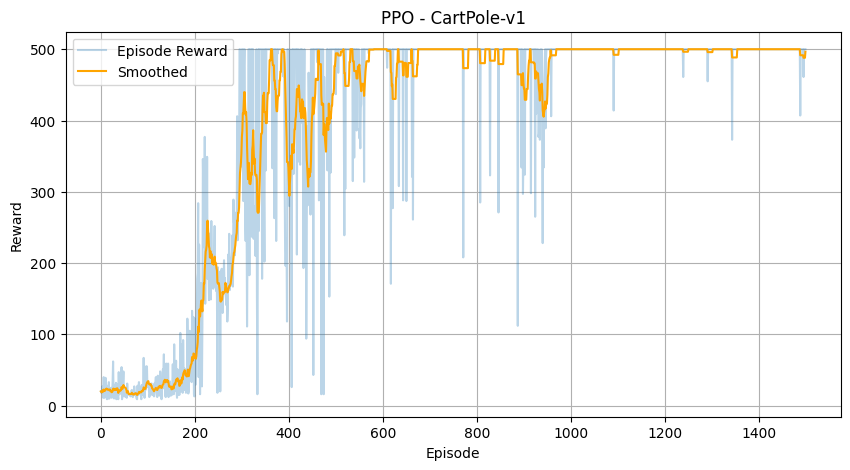

Eval Episode 1: 500.00
Eval Episode 2: 500.00
Eval Episode 3: 500.00
Eval Episode 4: 500.00
Eval Episode 5: 500.00
Eval Episode 6: 500.00
Eval Episode 7: 500.00
Eval Episode 8: 500.00
Eval Episode 9: 500.00
Eval Episode 10: 500.00


In [81]:
cartpole_model, cartpole_norm, cartpole_rewards = train_ppo(
    env_name="CartPole-v1", episodes=1500, is_continuous=False)
plot_training_rewards(cartpole_rewards, "CartPole-v1")
cartpole_eval = evaluate(cartpole_model, cartpole_norm, "CartPole-v1", is_continuous=False)

Episode 1/1500, Reward: -97.66, Avg100: -97.66
Episode 100/1500, Reward: -301.87, Avg100: -196.70
Episode 200/1500, Reward: -229.54, Avg100: -163.80
Episode 300/1500, Reward: -77.26, Avg100: -112.19
Episode 400/1500, Reward: -30.04, Avg100: -62.16
Episode 500/1500, Reward: -13.36, Avg100: 54.30
Episode 600/1500, Reward: 272.66, Avg100: 162.93
Episode 700/1500, Reward: 268.22, Avg100: 197.85
Episode 800/1500, Reward: 262.24, Avg100: 190.85
Episode 900/1500, Reward: 283.35, Avg100: 168.53
Episode 1000/1500, Reward: 272.26, Avg100: 210.68
Episode 1100/1500, Reward: 261.68, Avg100: 233.74
Episode 1200/1500, Reward: 239.70, Avg100: 198.71
Episode 1300/1500, Reward: -67.46, Avg100: 167.80
Episode 1400/1500, Reward: 267.17, Avg100: 233.84
Episode 1500/1500, Reward: 239.81, Avg100: 235.11


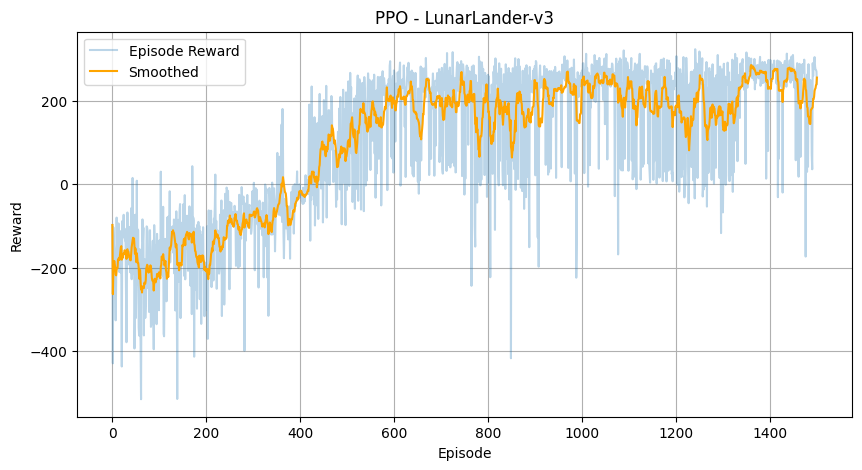

Eval Episode 1: 241.58
Eval Episode 2: 246.92
Eval Episode 3: -2.67
Eval Episode 4: 207.94
Eval Episode 5: 228.00
Eval Episode 6: 212.43
Eval Episode 7: 227.71
Eval Episode 8: 210.90
Eval Episode 9: 243.27
Eval Episode 10: 56.65


In [82]:
lunar_model, lunar_norm, lunar_rewards = train_ppo(
    env_name="LunarLander-v3", episodes=1500, is_continuous=False)
plot_training_rewards(lunar_rewards, "LunarLander-v3")
lunar_eval = evaluate(lunar_model, lunar_norm, "LunarLander-v3", is_continuous=False)

Episode 1/1500, Reward: -100.13, Avg100: -100.13
Episode 100/1500, Reward: -102.63, Avg100: -106.77
Episode 200/1500, Reward: -102.26, Avg100: -104.34
Episode 300/1500, Reward: -106.87, Avg100: -103.76
Episode 400/1500, Reward: -107.03, Avg100: -104.04
Episode 500/1500, Reward: -103.11, Avg100: -103.55
Episode 600/1500, Reward: -103.21, Avg100: -103.75
Episode 700/1500, Reward: -101.76, Avg100: -103.40
Episode 800/1500, Reward: -103.12, Avg100: -103.32
Episode 900/1500, Reward: -101.72, Avg100: -102.85
Episode 1000/1500, Reward: -103.13, Avg100: -103.01
Episode 1100/1500, Reward: -101.89, Avg100: -102.65
Episode 1200/1500, Reward: -103.33, Avg100: -102.70
Episode 1300/1500, Reward: -102.84, Avg100: -102.52
Episode 1400/1500, Reward: -102.50, Avg100: -102.46
Episode 1500/1500, Reward: -101.78, Avg100: -102.23


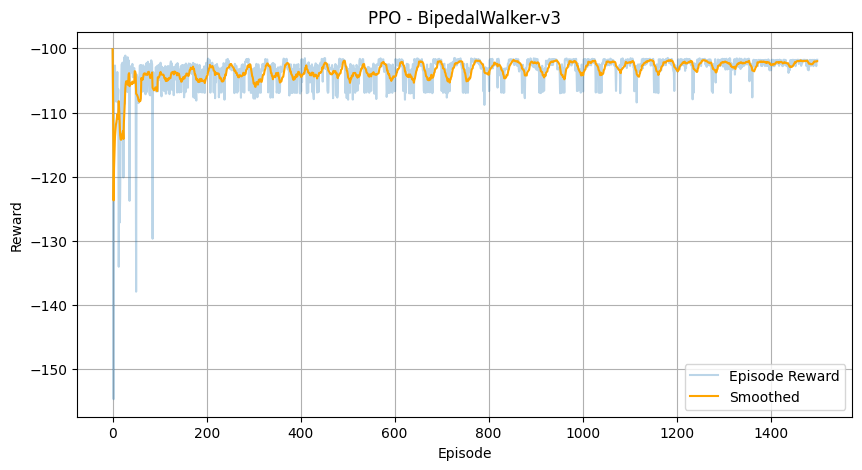

Eval Episode 1: -103.43
Eval Episode 2: -103.31
Eval Episode 3: -101.83
Eval Episode 4: -102.56
Eval Episode 5: -107.01
Eval Episode 6: -103.43
Eval Episode 7: -103.45
Eval Episode 8: -103.43
Eval Episode 9: -103.31
Eval Episode 10: -103.31


In [83]:
biped_model, biped_norm, biped_rewards = train_ppo(
    env_name="BipedalWalker-v3", episodes=1500, is_continuous=True)
plot_training_rewards(biped_rewards, "BipedalWalker-v3")
biped_eval = evaluate(biped_model, biped_norm, "BipedalWalker-v3", is_continuous=True)